/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., activation="relu", input_shape=(28, 28, 1..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), kernel_regularizer=<keras.reg..., activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), kernel_regularizer=<keras.reg..., activation="relu", padding="same")`


Epoch 1/20
128/128 [==============================] - 4s 30ms/step - loss: 0.5372 - accuracy: 0.4880 - val_loss: 0.4982 - val_accuracy: 0.5020
Epoch 2/20
128/128 [==============================] - 2s 19ms/step - loss: 0.2736 - accuracy: 0.6385 - val_loss: 0.1412 - val_accuracy: 0.8034
Epoch 3/20
128/128 [==============================] - 3s 20ms/step - loss: 0.1759 - accuracy: 0.7539 - val_loss: 0.0941 - val_accuracy: 0.8953
Epoch 4/20
128/128 [==============================] - 3s 20ms/step - loss: 0.1283 - accuracy: 0.8401 - val_loss: 0.0746 - val_accuracy: 0.9214
Epoch 5/20
128/128 [==============================] - 3s 20ms/step - loss: 0.1146 - accuracy: 0.8704 - val_loss: 0.0652 - val_accuracy: 0.9373
Epoch 6/20
128/128 [==============================] - 3s 20ms/step - loss: 0.0987 - accuracy: 0.8926 - val_loss: 0.0561 - val_accuracy: 0.9471
Epoch 7/20
128/128 [==============================] - 3s 20ms/step - loss: 0.0924 - accuracy: 0.9040 - val_loss: 0.0519 - val_accuracy: 0.9620

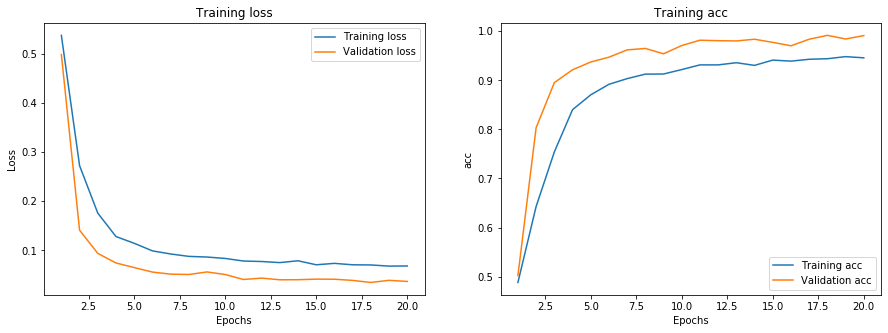

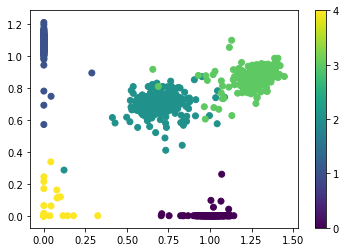

In [9]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score

num_class = 10
feature_dim = 2

train_num_list = list(range(5))
val_num_list = list(range(5))
test_num_list = list(range(7,10))
all_num_list = list(range(10))

################################################
############ data generation
################################################
class Data_MNIST:
  def __init__(self):
    self.prepare_data()
    self.group_data()

  def prepare_data(self):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    self.img_rows = x_train.shape[1]
    self.img_cols = x_train.shape[2]
    self.input_shape = (self.img_rows, self.img_cols,1)

    x_train = x_train.reshape(-1, self.img_rows, self.img_cols, 1)
    x_test = x_test.reshape(-1, self.img_rows, self.img_cols, 1)
    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    x_train /= 255.
    x_test /= 255.
    self.x_train = x_train
    self.x_test = x_test
    self.y_train = y_train
    self.y_test = y_test

  def group_data(self):
    self.grouped_data = {}
    self.grouped_test_data = {}
    for i in range(10):
      self.grouped_data[i] = self.x_train[self.y_train==i]
      self.grouped_test_data[i] = self.x_test[self.y_test==i]

  def get_batch(self, num_list, flag='train'):
    target = []
    batch = []
    if flag  == 'train':
      data_ = self.grouped_data
    else:
      data_ = self.grouped_test_data
    num_example = min([data_[i].shape[0] for i in num_list])

    for i in range(num_example):
      i1,i2 = np.random.choice(num_list,2, replace=False)
      i_index = np.random.choice(num_example,4, replace=False)
      batch += [[data_[i1][i_index[0]], data_[i1][i_index[1]]]]
      batch += [[data_[i1][i_index[2]], data_[i2][i_index[3]]]]
      target.append(1)
      target.append(0)
    return np.array(batch), np.array(target)

  def get_test_batch(self, test_size, test_target, categ_target, k=10):#k-way one shot learning
    batch = [np.zeros((test_size*k, self.img_rows, self.img_cols,1)) for i in range(2)]
    # batch = []
    target = [] # index of correct category
    num_list = test_target
    categ_list = categ_target
    data_ = self.grouped_data
    for i in range(test_size):
      i1 = np.random.choice(num_list)
      i1_index = np.random.choice(data_[i1].shape[0])
      batch[0][i*k:i*k+k,:] = np.repeat(data_[i1][i1_index][np.newaxis,:], k, axis=0)
      target.append(i1)
      for k_i in range(k):
        i2_index = np.random.choice(data_[categ_list[k_i]].shape[0])
        batch[1][i*k+k_i,:] = data_[categ_list[k_i]][i2_index]
        while categ_list[k_i]==i1 and i2_index == i1_index:
          i2_index = np.random.choice(data_[categ_list[k_i]].shape[0])
          batch[1][i*k+k_i,:] = data_[categ_list[k_i]][i2_index]
      
    return batch, target


################################################
############ Model Building
################################################

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
  '''Contrastive loss from Hadsell-et-al.'06
  http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
  '''
  margin = 1
  square_pred = K.square(y_pred)
  margin_square = K.square(K.maximum(margin - y_pred, 0))
  return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def get_siamese_model(input_shape, distance = 'l1'):
    
  left_input = Input(input_shape, name='input1')
  right_input = Input(input_shape, name='input2')

  model = Sequential()
  model.add(Conv2D(128, 3, 3, kernel_regularizer=regularizers.l2(0.0001), border_mode='same', activation="relu", input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
  model.add(Dropout(0.5))
  model.add(Conv2D(256, 3, 3, kernel_regularizer=regularizers.l2(0.0001), border_mode='same', activation="relu")) 
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
  model.add(Dropout(0.3))
  model.add(Conv2D(512, 3, 3, kernel_regularizer=regularizers.l2(0.0001), border_mode='same', activation="relu")) 
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(2, activation='relu'))

  encoded_l = model(left_input)
  encoded_r = model(right_input)

  if distance == 'l1':
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)

    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

  else:
    distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([encoded_l, encoded_r])

    siamese_net = Model([left_input,right_input], distance)
  return siamese_net


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

def get_model_performance(model, batch, targets, val_batch, val_targets):
  y_pred = model.predict([batch[:, 0], batch[:, 1]])
  tr_acc = np.mean(((y_pred.ravel() < 0.5) == targets))
  y_pred = model.predict([val_batch[:, 0], val_batch[:, 1]])
  te_acc = np.mean(((y_pred.ravel() < 0.5) == val_targets))

  print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
  print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

def get_one_shot_performance(model, data, distance):
  test_size = 10240
  batch, target = data.get_test_batch(test_size, test_num_list, all_num_list, k=10)
  y_pre = model.predict(batch)
  if distance == 'l1':
    pre = np.argmax(y_pre.reshape(-1,len(all_num_list)),axis=1)
  else:
    pre = np.argmin(y_pre.reshape(-1,len(all_num_list)),axis=1)
  return accuracy_score(target, pre)

################################################
############ Feature Model
################################################

def get_feature_model(model):
  feature_model = Model(inputs=model.input, outputs=model.layers[3].input)
  return feature_model

def get_features(feature_model, data):
  data_sz = data.shape[0]
  if data_sz%2 == 0:
    features = feature_model.predict([data[:data_sz//2], data[data_sz//2:]])
    return np.concatenate((features[0], features[1]), axis = 0)
  else:
    features = feature_model.predict([data[:data_sz//2], data[data_sz//2:-1]])
    features = np.concatenate((features[0], features[1]), axis = 0)
    last_feature = feature_model.predict([data[-1][np.newaxis,:], data[-1][np.newaxis,:]])[0]
    return np.concatenate((features, last_feature), axis = 0)


def get_features_(feature_model, data):
  features = feature_model.predict([data, data])
  return features[0]

def get_labeled_features(feature_model, data, list_labels):
  features = np.array([]).reshape((0,feature_dim))
  targets = []
  for i in list_labels:
    data_ = data.grouped_data[i][::30]
    features_ = get_features_(feature_model, data_)
    features = np.concatenate((features, features_), axis = 0)
    targets_ = [i] * features_.shape[0]
    targets += targets_
  return features, targets

################################################
############ Plot
################################################

def plot_history(history, with_val = False):
  history_dict = history.history
  loss_values = history_dict['loss']
  if with_val:
    val_loss_values = history_dict['val_loss']
  epochs = range(1, len(loss_values) + 1)
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, label='Training loss')
  if with_val:
    plt.plot(epochs, val_loss_values, label='Validation loss')
  plt.title('Training loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  acc = history_dict['accuracy']
  if with_val:
    val_acc = history_dict['val_accuracy']
  plt.subplot(1,2,2)
  plt.plot(epochs, acc, label='Training acc')
  if with_val:
    plt.plot(epochs, val_acc, label='Validation acc')
  plt.title('Training acc')
  plt.xlabel('Epochs')
  plt.ylabel('acc')
  plt.legend()
  
  plt.show()

def plot_feature(features, labels):
  if feature_dim == 2:
    plt.scatter(features[:,0], features[:,1], c=labels)
    plt.colorbar(ticks=range(10))
  else:
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(features[:,0], features[:,1], features[:,2], c=labels)
    plt.colorbar(ticks=range(10))
  plt.show()

################################################
################################################

epochs = 20
batch_size = 128

data = Data_MNIST()

batch, targets = data.get_batch(train_num_list, 'train')
val_batch, val_targets = data.get_batch(val_num_list, 'val')
input_shape = data.input_shape

distance = 'euclidean'
# distance = 'l1'
model= get_siamese_model(input_shape, distance)

rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
plot_model(model, show_shapes=True, show_layer_names=True)



train_datagen = ImageDataGenerator(rotation_range=2, width_shift_range=0.15, height_shift_range=0.15, shear_range=0.1, zoom_range=0.1, horizontal_flip=True)

train_set = train_datagen.flow([batch[:, 0], batch[:, 1]], targets)

validation_datagen = ImageDataGenerator()
validation_set = validation_datagen.flow([val_batch[:, 0], val_batch[:, 1]], val_targets)

history = model.fit_generator(train_set,
                    steps_per_epoch=128,epochs=epochs,
                    validation_data=(validation_set), validation_steps=64, shuffle=True)

get_model_performance(model, batch, targets, val_batch, val_targets)
plot_history(history, with_val=True)

feature_model = get_feature_model(model)
features, labels = get_labeled_features(feature_model, data, train_num_list)
plot_feature(features, labels)

In [10]:
get_one_shot_performance(model, data, distance)

0.3943359375